Setting Library

In [308]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

Load data

In [309]:
def crawl(company):
    start = "2020-01-15" 
    end = today = dt.datetime.now().strftime("%Y-%m-%d") 
    df = vnstock.stock_historical_data(symbol = company, start_date = start, end_date = end)
    df.to_csv(f"./data/raw/{company}.csv",encoding = "utf-8")

fhandle = open("./data/companylist.txt","r")
for line in fhandle.readlines():
    company = line.strip()
    print(f"{company}'s stock", end=' ')
    crawl(company)

FPT's stock CTG's stock LCG's stock 

In [310]:
#Company list
companies = []
fhandle = open("./data/companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock


In [311]:
def get_data_for_xgb(filename):
    _df = pd.read_csv(filename)
    _df = _df.drop(["Unnamed: 0", "TradingDate"], axis=1)
    train_size = int(len(_df.values)*0.8)
    train_df = _df.iloc[:train_size]
    valid_df = _df.iloc[train_size:]
    scaler_train = MinMaxScaler(feature_range = (0, 1))
    scaler_valid = MinMaxScaler(feature_range = (0, 1))
    scale_train_df = scaler_train.fit_transform(train_df.values)
    scale_valid_df = scaler_valid.fit_transform(valid_df.values)
    train_df = pd.DataFrame(data=scale_train_df, columns=_df.columns)
    valid_df = pd.DataFrame(data=scale_valid_df, columns=_df.columns)
    return train_df, valid_df, scaler_train, scaler_valid

In [312]:
company = 'FPT'
df = pd.read_csv(f"data/raw/{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,33119.0,33816.0,33119.0,33700.0,1942970,2020-01-16
1,1,33700.0,33758.0,33119.0,33467.0,1388810,2020-01-17
2,2,33409.0,33700.0,33235.0,33351.0,1227100,2020-01-20
3,3,33584.0,33700.0,32247.0,32247.0,4351820,2020-01-21
4,4,31957.0,32828.0,31782.0,32828.0,3165650,2020-01-22
...,...,...,...,...,...,...,...
765,765,80700.0,81200.0,80000.0,80700.0,614692,2023-02-13
766,766,80700.0,81000.0,80200.0,80800.0,621417,2023-02-14
767,767,80500.0,81900.0,80300.0,81600.0,646219,2023-02-15
768,768,81600.0,82000.0,80700.0,81600.0,425495,2023-02-16


Preprocessing data

In [313]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [314]:
#Candlesticks
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

#Labels
MA1 = 7
MA2 = 14
MA3 = 21
MA4 = 28

df['AR'] = df['H-L']/df['O-C']
#Median
df[f'ME_{MA1}'] = df['Close'].rolling(window = MA1).median()
df[f'ME_{MA2}'] = df['Close'].rolling(window = MA2).median()
df[f'ME_{MA3}'] = df['Close'].rolling(window = MA3).median()
df[f'ME_{MA4}'] = df['Close'].rolling(window = MA4).median()
#Rank 
df[f'RANK_{MA1}'] = df['Close'].rolling(window = MA1).rank()
df[f'RANK_{MA2}'] = df['Close'].rolling(window = MA2).rank()
df[f'RANK_{MA3}'] = df['Close'].rolling(window = MA3).rank()
df[f'RANK_{MA4}'] = df['Close'].rolling(window = MA4).rank()

#Var
df[f'VAR_{MA1}'] = df['Close'].rolling(window = MA1).var()
df[f'VAR_{MA2}'] = df['Close'].rolling(window = MA2).var()
df[f'VAR_{MA3}'] = df['Close'].rolling(window = MA3).var()
df[f'VAR_{MA4}'] = df['Close'].rolling(window = MA4).var()

#Simple moving average
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()
df[f'SMA_{MA4}'] = df['Close'].rolling(window = MA4).mean()

#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA2}'] = df['Close'].rolling(window = MA2).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()
df[f'SD_{MA4}'] = df['Close'].rolling(window = MA4).std()

#Skewness
df[f'Ske_{MA1}'] = df['Close'].rolling(window = MA1).skew()
df[f'Ske_{MA2}'] = df['Close'].rolling(window = MA2).skew()
df[f'Ske_{MA3}'] = df['Close'].rolling(window = MA3).skew()
df[f'Ske_{MA4}'] = df['Close'].rolling(window = MA4).skew()

#Kurtosis
df[f'Kur_{MA1}'] = df['Close'].rolling(window = MA1).kurt()
df[f'Kur_{MA2}'] = df['Close'].rolling(window = MA2).kurt()
df[f'Kur_{MA3}'] = df['Close'].rolling(window = MA3).kurt()
df[f'Kur_{MA4}'] = df['Close'].rolling(window = MA4).kurt()

df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis = 1)]
#Drop missing data
df.dropna(inplace = True)


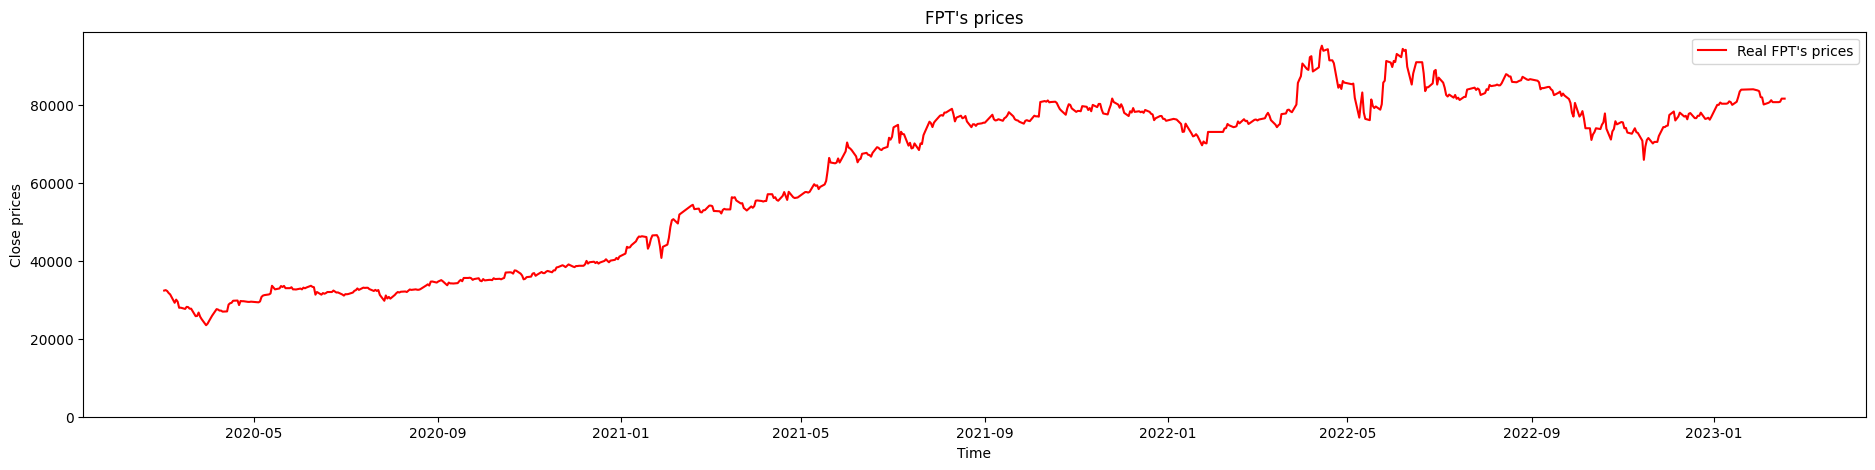

In [315]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (23,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() 
plt.show()

In [316]:
#Exporting data
df.to_csv(f"data\prepaired/{company}pre.csv", encoding = "utf-8")

Processing Data

In [317]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [318]:
#Fit data
cols_x = ['H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}']
cols_y = ['Close']
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [319]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,H-L,O-C,AR,...,SD_21,SD_28,Ske_7,Ske_14,Ske_21,Ske_28,Kur_7,Kur_14,Kur_21,Kur_28
27,27,32015.0,32654.0,31841.0,32364.0,1787060,2020-03-02,813.0,-349.0,-2.329513,...,822.178868,1030.508810,-1.161866,-0.788379,-0.347562,0.050891,1.481544,0.766863,-0.907817,-0.612280
28,28,32654.0,33119.0,32364.0,32480.0,1193800,2020-03-03,755.0,174.0,4.339080,...,775.695384,966.695591,-1.329729,-1.061289,-0.396084,-0.124220,1.356935,1.207903,-0.861868,-0.677261
29,29,32247.0,32247.0,31899.0,32247.0,1660790,2020-03-04,348.0,0.0,inf,...,713.311356,907.838671,-1.216103,-1.352764,-0.467931,-0.299519,1.453299,1.949859,-0.757901,-0.714949
30,30,32247.0,32480.0,31724.0,31724.0,1296450,2020-03-05,756.0,523.0,1.445507,...,632.267608,842.267030,-0.397156,-1.386952,-0.396097,-0.501344,-1.173580,2.087743,-0.760794,-0.820772
31,31,31492.0,31550.0,31085.0,31376.0,1305030,2020-03-06,465.0,116.0,4.008621,...,623.487763,831.830454,-0.872488,-1.326069,-0.436504,-0.422820,-0.334081,1.731924,-0.612545,-0.796433


In [320]:
#Training seq X and output value Y
pre_day = 7
x_total = [] # Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i - pre_day : i])
    y_total.append(scaled_data_y[i])

In [321]:
#Set test
test_size = 365

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set (0, 30)
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set (31,...)
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
eval_set = [(x_train, y_train), (x_test, y_test)]

(371, 7, 31) (371, 1) (365, 7, 31) (365, 1)


Build Model

In [322]:
# #Layers
def CreateModel(cells = 248):
    model = Sequential()
    model.add(LSTM(units = cells, activation='tanh', recurrent_activation='sigmoid', input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
    model.add(Dropout(0.1))
    model.add(Dense(units = len(cols_y)))                     
    return model
model = CreateModel()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs = 10, batch_size = 2, use_multiprocessing = True, validation_split=0.2, shuffle=True)#Fit input to taget

Epoch 1/10
148/148 [==============================] - 3s 8ms/step - loss: 0.0049 - accuracy: 0.0034 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 2/10
148/148 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.0034 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 3/10
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.0034 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/10
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.0034 - val_loss: 8.7245e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
148/148 [==============================] - 1s 7ms/step - loss: 6.2551e-04 - accuracy: 0.0034 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 6/10
148/148 [==============================] - 1s 6ms/step - loss: 7.2690e-04 - accuracy: 0.0034 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/10
148/148 [==============================] - 1s 6ms/step - loss: 7.6080e-04 - accuracy: 0.0034 - val_lo

12/12 [==============================] - 0s 4ms/step


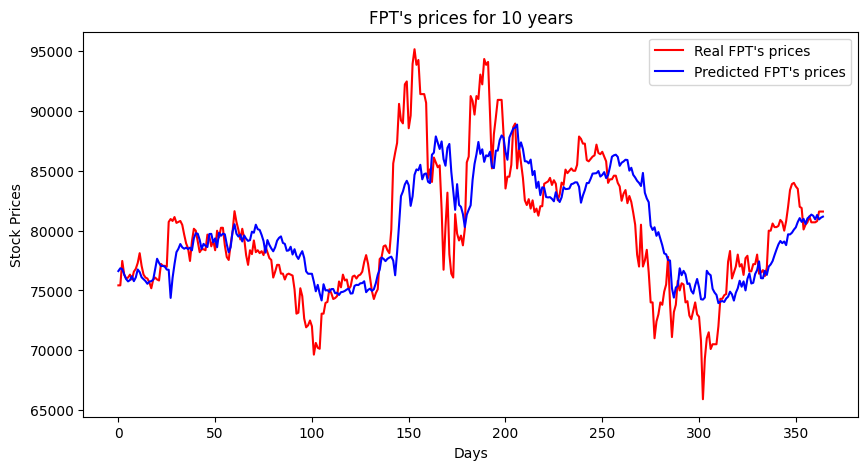

In [323]:
#Config real price
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

#Config predicted price
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

#Predicted days
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(real_price, color="red", label=f"Real {company}'s prices")
ax.plot(predict_prices, color="blue", label=f"Predicted {company}'s prices")
ax.set_title(f"{company}'s prices for 10 years")
ax.set_xlabel("Days")
ax.set_ylabel("Stock Prices")
ax.legend()
plt.show()

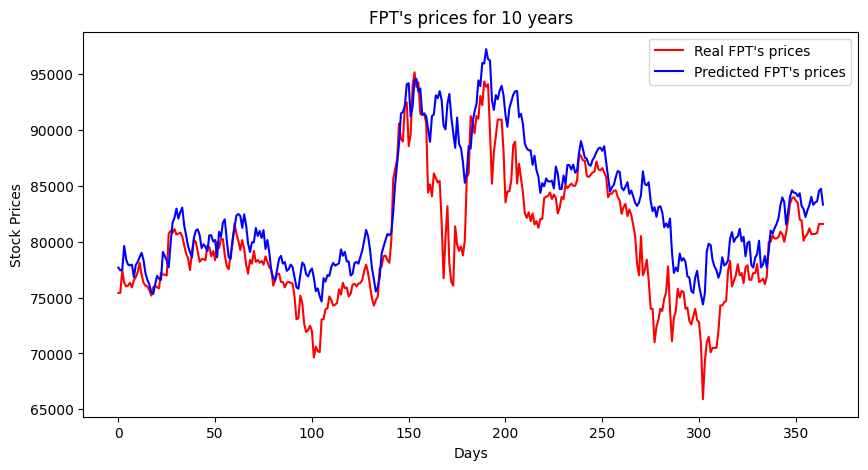

2019
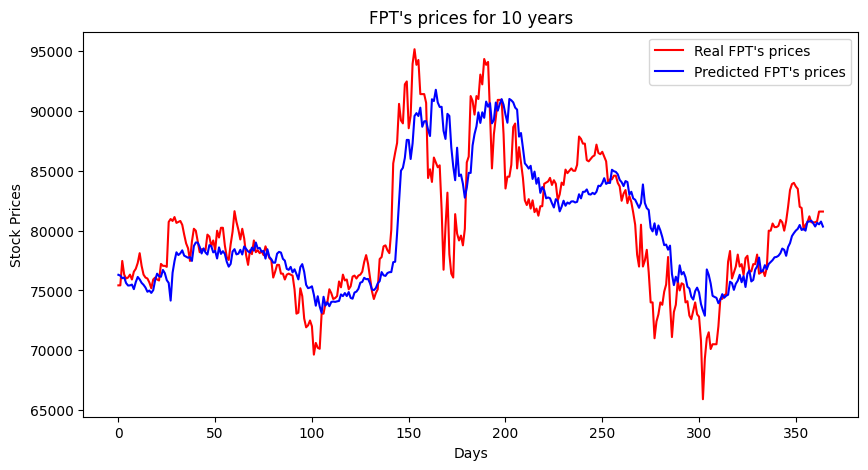

In [324]:
#Save model
from keras.models import save_model

save_model(model, f"model/{company}.h5", include_optimizer = True)

# Deploy product

Load model

1/1 [==============================] - 0s 293ms/step


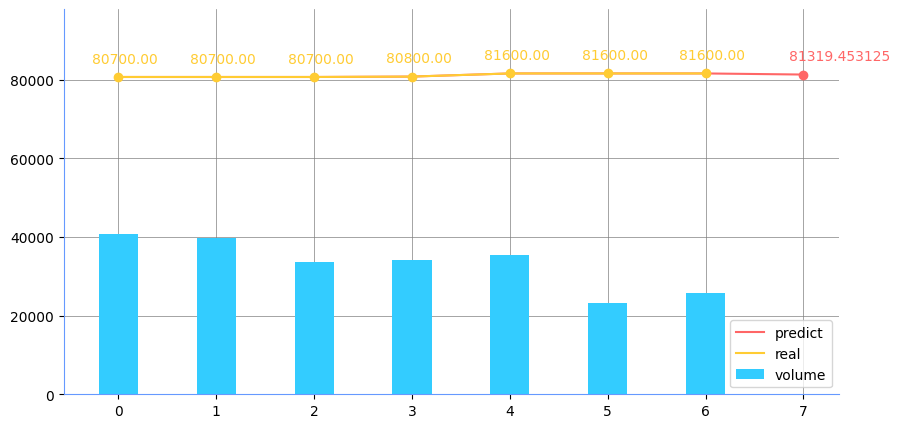

In [325]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM    
# company = 'HAG'
df = pd.read_csv(f"./data/prepaired/{company}pre.csv", encoding = "utf-8")
MA1 = 7
MA2 = 14
MA3 = 21
MA4 = 28
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))
cols_x = ['H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}'] #Variables for training
cols_y = ['Close']
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
model = Sequential()
cells = 128
model.add(LSTM(units = cells, activation='tanh', recurrent_activation='sigmoid', input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
model.add(Dropout(0.1))
model.add(Dense(units = len(cols_y)))  
model = load_model(f"./model/{company}.h5")
real_prices = df.loc[len(df)-7:, ['Close', 'Volume']]
real_prices = np.array(real_prices)
predict_prices = real_prices[:, 0]
x_predict = df[len(df)-7:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scaler_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))
prediction = model.predict(x_predict)
prediction = scaler_y.inverse_transform(prediction)
predict_prices = np.append(predict_prices, prediction)
font = "Segoe UI"  
font_color = "black"  
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(True, linewidth=0.5, color='gray', zorder=1)
if predict_prices[6] < predict_prices[7]:
    ax.plot(predict_prices, color="#58D68D", label=f"predict", zorder=2)
else:
    ax.plot(predict_prices, color="#FF6666", label=f"predict", zorder=2)
ax.plot(real_prices[:, 0], color="#FFCC33", label=f"real", zorder=2)
real_volumes = np.multiply(real_prices[:, 1], (np.max(predict_prices)/2/(np.max(real_prices[:, 1]))))
x = np.arange(len(real_volumes))  
width = 0.4  
ax.bar(x - width/2, real_volumes , width, color="#33CCFF", label='volume', align='edge', zorder=2)
ax.scatter(np.arange(len(real_prices[:, 0])), real_prices[:, 0], color='#FFCC33', zorder=2)
for i, price in enumerate(real_prices[:, 0]):
    ax.annotate(f"{price:.2f}", (i, real_prices[i, 0]), xytext=(5, 10), textcoords='offset points', color='#FFCC33', ha='center', zorder=2)
if predict_prices[6] < predict_prices[7]:
    ax.scatter(len(predict_prices)-1, predict_prices[-1], color="#58D68D", zorder=2)
    ax.annotate(predict_prices[-1], xy=(len(predict_prices)-1, predict_prices[-1]), xytext=(-10, 10), textcoords='offset points', color="#58D68D",zorder=2 )
else:
    ax.scatter(len(predict_prices)-1, predict_prices[-1], color="#FF6666", zorder=2)
    ax.annotate(predict_prices[-1], xy=(len(predict_prices)-1, predict_prices[-1]), xytext=(-10, 10), textcoords='offset points', color="#FF6666", zorder=2)
ax.legend(loc= 'lower right')
ax.spines['bottom'].set_color('#6699FF')
ax.spines['left'].set_color('#6699FF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(colors=font_color)

ax.set_ylim(0, np.max(predict_prices)*1.2)
# plt.savefig(f"./gui/images/svg_images/{company}.svg", format="svg", transparent=True)
plt.show()

#Relationship



12/12 [==============================] - 0s 5ms/step


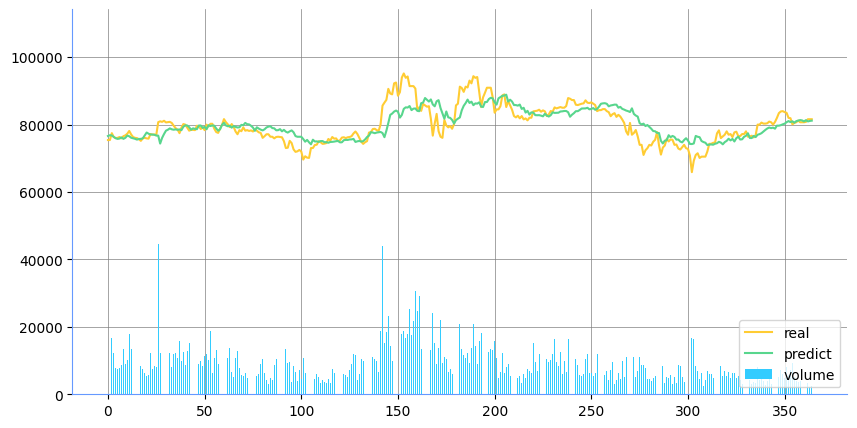

In [326]:
real_prices = df.loc[len(df)-365:, ['Close', 'Volume']]
real_prices = np.array(real_prices)
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)
font = "Segoe UI"  
font_color = "black"  
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(True, linewidth=0.5, color='gray', zorder=1)
ax.plot(real_prices[:, 0], color="#FFCC33", label=f"real", zorder=2)
ax.plot(predict_prices, color="#58D68D", label=f"predict", zorder=2)
real_volumes = np.multiply(real_prices[:, 1], (np.max(predict_prices)/2/(np.max(real_prices[:, 1]))))
x = np.arange(len(real_volumes))  
width = 0.4  
ax.bar(x - width/2, real_volumes , width, color="#33CCFF", label='volume', align='edge', zorder=2)
ax.legend(loc= 'lower right')
ax.spines['bottom'].set_color('#6699FF')
ax.spines['left'].set_color('#6699FF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(colors=font_color)
ax.set_ylim(0, max(np.max(predict_prices)*1.2, np.max(real_prices[:, 0])*1.2))
plt.show()